In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive'


MyDrive  Shareddrives


In [5]:
#Give dataset path
train_path = '/content/drive/MyDrive/Dataset/TRAIN'
test_path = '/content/drive/MyDrive/Dataset/TEST'

Working with 486 images
Image examples: 
ecosport162.jpg


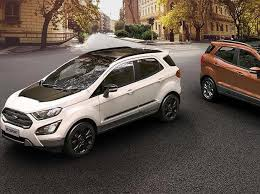

ecosport193.jpg


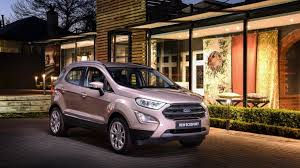

ecosport224.jpg


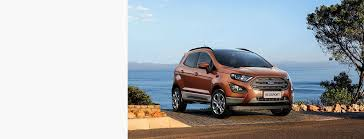

ecosport178.jpg


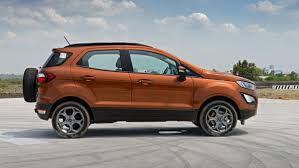

ecosport208.jpg


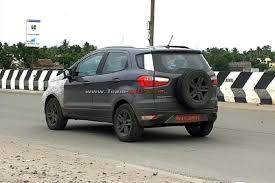

ecosport239.jpg


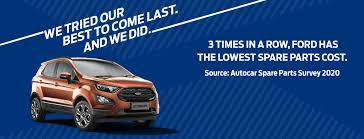

ecosport256.jpg


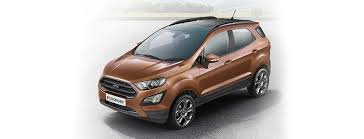

ecosport274.jpg


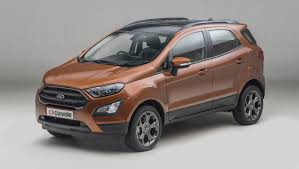

ecosport277.jpg


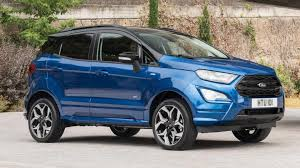

In [7]:
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis
# creating a object  

  
folder = train_path+'/ECO-TRAIN'


onlyECOfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
print("Working with {0} images".format(len(onlyECOfiles)))
print("Image examples: ")


for i in range(9):
    print(onlyECOfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyECOfiles[i], width=240, height=240))

In [8]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [9]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [10]:
for layer in vgg.layers:
  layer.trainable = False

In [11]:
folders = glob('/content/drive/MyDrive/Dataset/TRAIN/*')
print(len(folders))

3


In [12]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
from keras import optimizers


adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [14]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [15]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [16]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1398 images belonging to 3 classes.


In [17]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 150 images belonging to 3 classes.


In [18]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
5/5 - 141s - loss: 9.5039 - accuracy: 0.3400 - val_loss: 6.0952 - val_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 6.09521, saving model to mymodel.h5
Epoch 2/10
5/5 - 43s - loss: 6.4166 - accuracy: 0.5125
Epoch 3/10
5/5 - 36s - loss: 6.2784 - accuracy: 0.5188
Epoch 4/10
5/5 - 33s - loss: 5.0142 - accuracy: 0.5500
Epoch 5/10
5/5 - 31s - loss: 4.5178 - accuracy: 0.5562
Epoch 6/10
5/5 - 23s - loss: 4.2477 - accuracy: 0.5562
Epoch 7/10
5/5 - 24s - loss: 3.7797 - accuracy: 0.6625
Epoch 8/10
5/5 - 22s - loss: 3.0715 - accuracy: 0.6562
Epoch 9/10
5/5 - 17s - loss: 2.5442 - accuracy: 0.7375
Epoch 10/10
5/5 - 13s - loss: 3.0993 - accuracy: 0.6625
Training completed in time:  0:08:03.473215


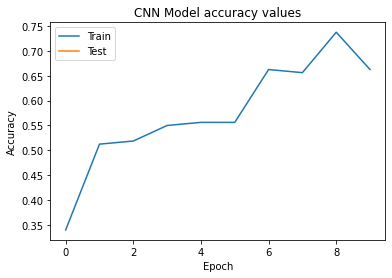

In [19]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [20]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [23]:
img_path=('/content/drive/MyDrive/Dataset/TEST/BAL-TEST/baleno11.jpg')
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
prediction

array([[1., 0., 0.]], dtype=float32)

In [22]:
img_path=('/content/drive/MyDrive/Dataset/TEST/ECO-TEST/ecosport11.jpg')
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
prediction

array([[0.00265376, 0.9960194 , 0.00132687]], dtype=float32)

In [26]:
img_path=('/content/drive/MyDrive/Dataset/TEST/MICRA-TEST/micra12.jpg')
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
prediction

array([[2.3450502e-14, 2.5967483e-26, 1.0000000e+00]], dtype=float32)